In [ ]:
from google.colab import drive

# 자신의 google drive에 연결합니다.
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/archive.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Garbage_Dataset_Classification/images/paper/paper_03049.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03050.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03052.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03053.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03054.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03055.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03056.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03057.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03058.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03061.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03063.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_03065.jpg  
  inflating: Garbage_Dataset_Classification/images/paper/paper_0

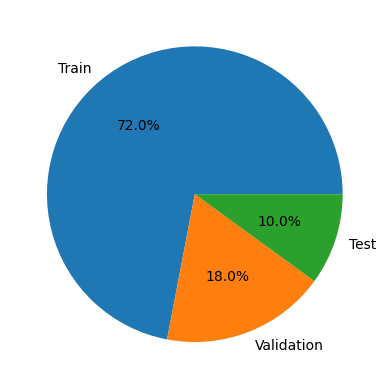

In [ ]:
import os # os(Operating System)모듈은 파이썬에서 운영체제에 쉽게 접근할 수 있도록 해주는 모듈입니다. os 모듈 공부?
import pandas as pd #pandas잘 모른는데 공부어케함?
import matplotlib.pyplot as plt
import cv2 #이건 csv ?

from sklearn.model_selection import train_test_split #이건 뭔가

image_paths = [] #이미지 경로
labels = [] # 실제 정답 값

for dirname, _, filenames in os.walk("/content/Garbage_Dataset_Classification"): #?? 포문을 이렇게 쓰는건 뭐며 walk는 뭐지? ,_,는 뭐
    for filename in filenames:
        image_path = os.path.join(dirname, filename) #walk쓰면 파일의 경로 ,?,파일 이름을 ???의 형태로 반환
        image_paths.append(image_path) #image_path에는 /content/Garbage_Dataset_Classification/images/plastic/plastic_00517.jpg 형태로 저장

        if 'cardboard_' in image_path:
            labels.append('cardboard')
        elif 'glass_' in image_path:
            labels.append('glass')
        elif 'metal_' in image_path:
            labels.append('metal')
        elif 'paper' in image_path:
            labels.append('paper')
        elif 'plastic' in image_path:
            labels.append('plastic')
        elif 'trash' in image_path:
            labels.append('trash')
        else:
            labels.append('None')
        #이 이프문을 지난 후 : labels에 각각의 방번호에 맞게 정답이 들어감
image_paths.pop(0)
labels.pop(0) #리스트 첫번째에 metadata.csv가 들어가서 뺐어요

trashes_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels,
})
class_to_index = {
    'cardboard': 0,
    'glass': 1,
    'metal': 2,
    'paper': 3,
    'plastic': 4,
    'trash': 5
}

index_to_class = {
    0: 'cardboard',
    1: 'glass',
    2: 'metal',
    3: 'paper',
    4: 'plastic',
    5: 'trash'
}

trashes_df['label'] = trashes_df['label'].map(class_to_index)
train_df, test_df = train_test_split(trashes_df, stratify=trashes_df['label'], test_size=0.1)
train_df, val_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.2) #train_test_split은 잘 몰라서 그대로, 효율적인 비율?
test_df.drop(['label'], axis=1, inplace=True) #이걸 drop하는 이유는 얘는 예측하는 데이터라서 정답표를 땐?


ratio = [len(train_df['label']),len(val_df['label']),len(test_df['image_path'])]

vislabels = ['Train', 'Validation', 'Test']

plt.pie(ratio, labels=vislabels, autopct='%.1f%%')
plt.show()




In [ ]:
train_df.head()

,image_path,label
13138,/content/Garbage_Dataset_Classification/images...,2
11460,/content/Garbage_Dataset_Classification/images...,0
3689,/content/Garbage_Dataset_Classification/images...,3
4249,/content/Garbage_Dataset_Classification/images...,3
4877,/content/Garbage_Dataset_Classification/images...,4


In [ ]:
test_df.head() #잘된듯?

,image_path
10632,/content/Garbage_Dataset_Classification/images...
9434,/content/Garbage_Dataset_Classification/images...
5109,/content/Garbage_Dataset_Classification/images...
6202,/content/Garbage_Dataset_Classification/images...
6499,/content/Garbage_Dataset_Classification/images...


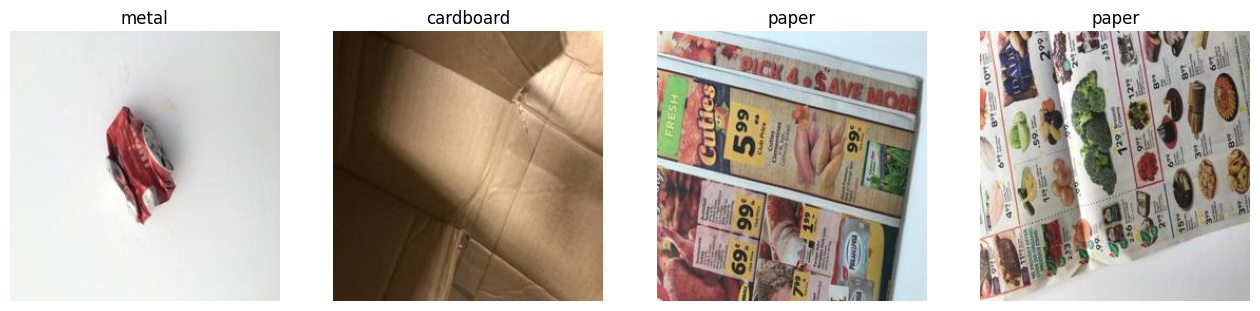

In [ ]:
def show_image(image_paths, labels=None, ncols=4):
    fig, axes = plt.subplots(figsize=(16, 8), ncols=ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_paths[i]), cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(index_to_class[labels[i]])
        axes[i].axis('off')

show_image(train_df['image_path'].values[:4], train_df['label'].values[:4]) # 시각화? 코드 이해안감 cv2 모름

In [ ]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class Custom_Dataset(Dataset):
    def __init__(self, image_paths, targets=None, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 이미지 로드
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Albumentations 적용
        if self.transform is not None:
            # ToTensorV2()가 포함되어 있다면 여기서 Tensor(CHW)로 변환됨
            image = self.transform(image=image)['image']

        # 타겟 처리
        if self.targets is not None:
            target = torch.tensor(self.targets[idx], dtype=torch.long)
            return image, target
        else:
            return image

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(224, 224), # 이미지 리사이징
    A.Normalize(), # float32로 픽셀 값 정규화
    A.ToTensorV2(), # 채널이 맨 앞으로 오게
])

custom_dataset = Custom_Dataset(train_df["image_path"].values, train_df["label"].values, transform)

In [ ]:
from torch.utils.data import DataLoader

custom_dataloader = DataLoader(custom_dataset, batch_size=16, shuffle=True, pin_memory=True)

In [ ]:
images, targets = next(iter(custom_dataloader))

print(f"images shape: {images.shape}")
print(f"targets shape: {targets.shape}")

images shape: torch.Size([16, 3, 224, 224])
targets shape: torch.Size([16])


In [ ]:
# Custom_Dataset 생성

train_dataset = Custom_Dataset(train_df["image_path"].values, train_df["label"].values, transform)
val_dataset = Custom_Dataset(val_df["image_path"].values, val_df["label"].values, transform)
test_dataset = Custom_Dataset(test_df["image_path"].values, None, transform)

In [ ]:
# Custom_DataLoader 생성

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True) #모델 예측할 때 원래 데이터 순서와 맞춰야 해서 shuffle=False로 바꿨어요

In [ ]:
!pip install torchinfo

In [ ]:
from torchvision import models
import torch.nn as nn
import torchinfo

def create_pretrained_model(model_name='efficientnet_b0', classifier_layer=None, image_size=[224, 224], make_summary=False):
  model = models.efficientnet_b0(weights='DEFAULT')
  model.classifier = classifier_layer

  if make_summary:
        # 모델 정보 요약(model summary)
        print(torchinfo.summary(model, input_size=[1, 3] + image_size,
                  col_names=['output_size', 'num_params', 'trainable'],
                  row_settings=['depth', 'var_names'],
                  depth=3))

  return model

classifier_layer = nn.Sequential(
    nn.Dropout(0.3), #Dropout 추가했더니 학습이 잘 됨
    nn.Linear(in_features=1280, out_features=6),
)

eff_model = create_pretrained_model(
    model_name = 'efficientnet_b0',
    classifier_layer = classifier_layer,
    make_summary=True
    )

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]


Layer (type (var_name):depth-idx)                                 Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                       [1, 6]                    --                        True
├─Sequential (features): 1-1                                      [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0): 2-1                              [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0): 3-1                                       [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1): 3-2                                  [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2): 3-3                                         [1, 32, 112, 112]         --                        --
│    └─Sequential (1): 2-2                                        [1, 16, 112, 112]         --                        True
│    │    └─M

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.3 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

# CNN 학습 Class
class Trainer:
    def __init__(self, model=None, train_dataloader=None, val_dataloader=None, loss_fn=None, auc_metric=None, acc_metric=None, optimizer=None):
        self.model = model
        self.val_dataloader = val_dataloader
        self.loss_fn = loss_fn
        self.auc_metric = auc_metric
        self.acc_metric = acc_metric
        self.optimizer = optimizer


    # 1번 에포크 학습 함수
    def train_epoch(self, train_dataloader): #train_dataloader
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.model = self.model.to(device)
        self.acc_metric = self.acc_metric.to(device)
        self.auc_metric = self.auc_metric.to(device)

        # 평균 loss를 구하기 위한 변수
        avg_loss = 0 #평균 loss값
        sum_loss = 0 #

        # 모델 학습 설정(model train setting)
        self.model.train()

        with tqdm(total = len(train_dataloader), desc="[Training...]", leave=True) as progress_bar:
            for batch_idx, (images, labels) in enumerate(train_dataloader):
                images = images.to(device)
                labels = labels.to(device)

                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                sum_loss += loss.item()
                avg_loss = sum_loss / (batch_idx+1)

                if self.auc_metric is not None:
                    self.auc_metric.update(F.softmax(logits, dim=-1), labels)
                if self.acc_metric is not None:
                    self.acc_metric.update(F.softmax(logits, dim=-1).argmax(dim=-1), labels)


                # 옵티마이저 초기화
                self.optimizer.zero_grad()

                # 오차 역전파(backpropagation)
                loss.backward()

                # 학습 파라미터 업데이트(parameter update)
                self.optimizer.step()

                # progress_bar update
                progress_bar.update(1)

                if batch_idx % 20 == 0 or batch_idx+1 == len(train_dataloader): #20번째 batch마다, 마지막 batch일 때 실행
                    current_auc = self.auc_metric.compute().item()
                    current_acc = self.acc_metric.compute().item()
                    progress_bar.set_postfix({
                        "Train_Loss" : avg_loss,
                        "Train_ACC" : current_acc,
                        "Train_AUC" : current_auc,
                    })

            self.auc_metric.reset()
            self.acc_metric.reset()

        return avg_loss, current_acc, current_auc

    # 1번 에포크 검증?
    def validate_epoch(self, val_dataloader): #val_dataloader
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.model = self.model.to(device)
        self.acc_metric = self.acc_metric.to(device)
        self.auc_metric = self.auc_metric.to(device)

        # 평균 loss를 구하기 위한 변수(variable for average loss)
        avg_loss = 0
        sum_loss = 0

        # 모델 평가로 설정(model evaluation setting)
        self.model.eval()

        with torch.no_grad():
            with tqdm(total = len(val_dataloader), desc="[Validating..] ", leave=True) as progress_bar:
                for batch_idx, (images, labels) in enumerate(val_dataloader):
                    images = images.to(device)
                    labels = labels.to(device)

                    logits = self.model(images)
                    loss = self.loss_fn(logits, labels)
                    sum_loss += loss.item()
                    avg_loss = sum_loss / (batch_idx+1)

                    if self.auc_metric is not None:
                        self.auc_metric.update(F.softmax(logits, dim=-1), labels)
                    if self.acc_metric is not None:
                        self.acc_metric.update(F.softmax(logits, dim=-1).argmax(dim=-1), labels)

                    # Progress bar Update
                    progress_bar.update(1)

                    if batch_idx % 20 == 0 or batch_idx+1 == len(val_dataloader):
                        # Progress_bar Update -> set_postfix
                        current_acc = self.acc_metric.compute().item()
                        current_auc = self.auc_metric.compute().item()
                        progress_bar.set_postfix({
                            "Validate_Loss" : avg_loss,
                            "Validate_ACC" : current_acc,
                            "Validate_AUC" : current_auc,
                            })

                self.acc_metric.reset()
                self.auc_metric.reset()

        return avg_loss, current_acc, current_auc

    # fit(train_epochs and val_epochs)
    def fit(self, epochs, train_dataloader=None, val_dataloader=None):
        history = {
            'train_loss' : [],
            'val_loss' : [],
            'train_acc' : [],
            'val_acc' : [],
            'train_auc' : [],
            'val_auc' : [],
        }

        for epoch in range(1, epochs+1):
            if train_dataloader is not None:
                train_loss, train_acc, train_auc = self.train_epoch(train_dataloader)
                history['train_loss'].append(train_loss); history['train_acc'].append(train_acc); history['train_auc'].append(train_auc)
            else:
                print("학습 데이터로더가 존재하지 않음!")
                return history

            if val_dataloader is not None:
                val_loss, val_acc, val_auc = self.validate_epoch(val_dataloader)
                history['val_loss'].append(val_loss); history['val_acc'].append(val_acc); history['val_auc'].append(val_auc)

        return history

    # 모델 평가
    def evaluate(self, eval_dataloader): #test_dataloader 사용?
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.model = self.model.to(device)
        self.acc_metric = self.acc_metric.to(device)
        self.auc_metric = self.auc_metric.to(device)

        # 평균 loss를 구하기 위한 변수(variable for average loss)
        avg_loss = 0
        sum_loss = 0

        # 모델 평가로 설정(model evaluation setting)
        self.model.eval()

        with torch.no_grad():
            with tqdm(total = len(eval_dataloader), desc="[Evaluating..] ", leave=True) as progress_bar:
                for batch_idx, (images, labels) in enumerate(eval_dataloader):
                    images = images.to(device)
                    labels = labels.to(device)


                    logits = self.model(images)
                    loss = self.loss_fn(logits, labels)
                    sum_loss += loss.item()
                    avg_loss = sum_loss / (batch_idx+1)

                    if self.auc_metric is not None:
                        self.auc_metric.update(F.softmax(logits, dim=-1), labels)
                    if self.acc_metric is not None:
                        self.acc_metric.update(F.softmax(logits, dim=-1).argmax(dim=-1), labels)

                    # Progress bar Update
                    progress_bar.update(1)

                    if batch_idx % 20 == 0 or batch_idx+1 == len(eval_dataloader):
                        # Progress_bar Update -> set_postfix
                        current_acc = self.acc_metric.compute().item()
                        current_auc = self.auc_metric.compute().item()
                        progress_bar.set_postfix({
                            "Evaluate_Loss" : avg_loss,
                            "Evaluate_ACC" : current_acc,
                            "Evaluate_AUC" : current_auc,
                            })

                self.acc_metric.reset()
                self.auc_metric.reset()

        return avg_loss, current_acc, current_auc

    # 마지막으로 학습된 모델 반환(return final trained model)
    def get_trained_model(self):
        return self.model

In [ ]:
from torch.optim import Adam
import torchmetrics

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(eff_model.parameters(), lr=0.0001)

auc_metric = torchmetrics.AUROC(task="multiclass", num_classes=6)
acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=6)

trainer =Trainer(
    model=eff_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    auc_metric=auc_metric,
    acc_metric=acc_metric,
    optimizer=optimizer)

In [ ]:
history = trainer.fit(epochs=10, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

[Training...]:   0%|          | 0/626 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
[Validating..] : 100%|██████████| 157/157 [00:06<00:00, 22.76it/s, Validate_Loss=0.2, Validate_ACC=0.957, Validate_AUC=0.996]


In [ ]:
torch.save(trainer.get_trained_model().state_dict(), "model.pth") #모델 저장

In [ ]:
trainer.evaluate(val_dataloader) #label이 있는 dataloader 사용

[Evaluating..] : 100%|██████████| 157/157 [00:07<00:00, 20.86it/s, Evaluate_Loss=0.195, Evaluate_ACC=0.957, Evaluate_AUC=0.996]


(0.19523964439475, 0.9572342038154602, 0.9961991310119629)

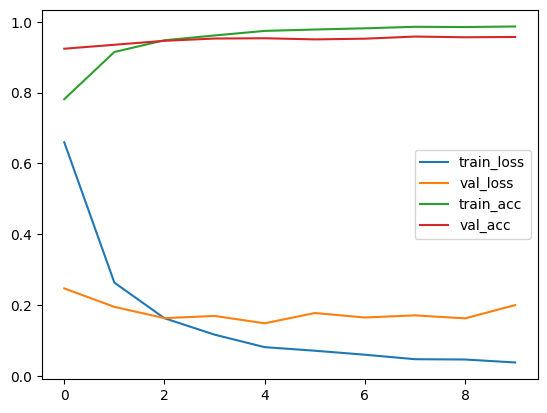

In [ ]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
# CNN 예측 Class
class Predictor:
    def __init__(self, model=None):
        self.model = model

    def predict(self, test_dataloader):
        pred_proba = self.predict_proba(test_dataloader)
        pred = pred_proba.argmax(dim=-1).cpu().numpy()

        return pred

    def predict_proba(self, test_dataloader):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        pred_probas = []

        self.model.to(device)
        self.model.eval()

        with torch.no_grad():
            with tqdm(total=len(test_dataloader), desc="[Predicting...] ", leave=True) as progress_bar:
                for batch_idx, images in enumerate(test_dataloader):
                    images = images.to(device) # images = images[0].to(device) -> fashion dataset 사용시 이걸로 바꿀 것

                    logit = self.model(images)

                    pred_proba = F.softmax(logit, dim=-1).cpu().numpy()

                    pred_probas.append(pred_proba)
                    progress_bar.update(1)

        final_result = np.concatenate(pred_probas, axis=0)

        return torch.tensor(final_result)


In [ ]:
predictor = Predictor(model=eff_model)

In [ ]:
preds = predictor.predict(test_dataloader)

[Predicting...] : 100%|██████████| 87/87 [00:05<00:00, 16.90it/s]


In [ ]:
preds

array([0, 1, 4, ..., 1, 0, 3])

In [ ]:
import pandas as pd

submission = pd.DataFrame({
    "image_path": test_df["image_path"],
    "label": preds
})

submission.to_csv("submission.csv", index=False)

In [ ]:
#예측한 데이터 시각화
submission_view = submission.copy()
submission_view["pred_label_name"] = submission_view["label"].map(index_to_class) #예측한 라벨 이름 추가

submission_view

,image_path,label,pred_label_name
10632,/content/Garbage_Dataset_Classification/images...,0,cardboard
9434,/content/Garbage_Dataset_Classification/images...,1,glass
5109,/content/Garbage_Dataset_Classification/images...,4,plastic
6202,/content/Garbage_Dataset_Classification/images...,4,plastic
6499,/content/Garbage_Dataset_Classification/images...,4,plastic
...,...,...,...
12855,/content/Garbage_Dataset_Classification/images...,2,metal
7488,/content/Garbage_Dataset_Classification/images...,1,glass
8623,/content/Garbage_Dataset_Classification/images...,1,glass
11038,/content/Garbage_Dataset_Classification/images...,0,cardboard
